In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import SVG

## Something similar to LeNet-5

* originally they excluded some connections between pooling and convolutional layers in order to force different representations
* `tanh` and `sigmoid` activations very used, the last layer did not include softmax and was not trained with categorical cross-entropy, instead it used some mix of MSE and regularization loss

In [2]:
layers = [
    tf.keras.layers.Input(shape=(32, 32, 1), batch_size=16, name='image'),
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', padding='valid', name='C1'), 
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), name='S1'),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='tanh', padding='valid', name='C2'),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), name='S2'),
    tf.keras.layers.Flatten(name='C3'),
    tf.keras.layers.Dense(120, activation='tanh', name='FC1'),
    tf.keras.layers.Dense(10, activation='softmax', name='FC2')
]

lenet = tf.keras.models.Sequential(layers=layers, name='LeNet-5')

lenet.summary()

Model: "LeNet-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (16, 28, 28, 6)           156       
_________________________________________________________________
S1 (AveragePooling2D)        (16, 14, 14, 6)           0         
_________________________________________________________________
C2 (Conv2D)                  (16, 10, 10, 16)          2416      
_________________________________________________________________
S2 (AveragePooling2D)        (16, 5, 5, 16)            0         
_________________________________________________________________
C3 (Flatten)                 (16, 400)                 0         
_________________________________________________________________
FC1 (Dense)                  (16, 120)                 48120     
_________________________________________________________________
FC2 (Dense)                  (16, 10)                  1210

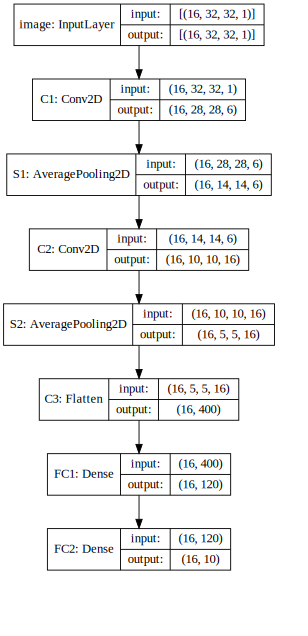

In [3]:
SVG(tf.keras.utils.model_to_dot(lenet, show_shapes=True, dpi=65
                               ).create(prog='dot', format='svg'))

## VGG16

* we are taking the short path to defining VGG16, it is basically straight-forward, two convolutional block with `3x3` kernels with `ReLU` activations followed by `MaxPooling`
* all high-level libraries have some kind of model collection
* here we are using the Tensorflow Keras API in order to load VGG16 

In [4]:
VGG16 = tf.keras.applications.VGG16(weights=None)

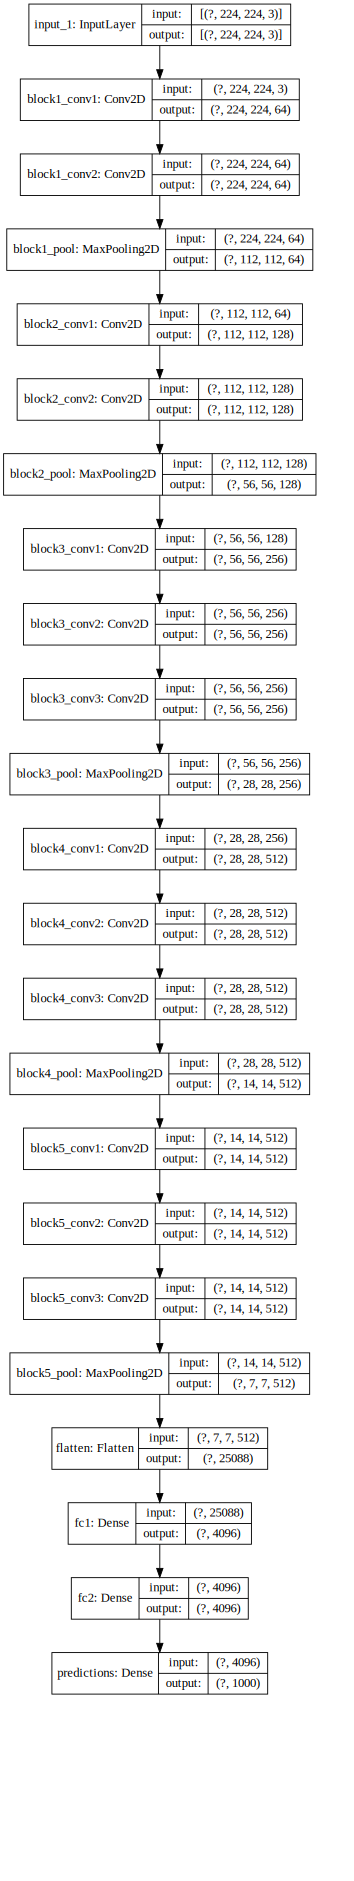

In [5]:
SVG(tf.keras.utils.model_to_dot(VGG16, show_shapes=True, dpi=65
                               ).create(prog='dot', format='svg'))

In [6]:
VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Inception module

* we are going to implement the naive and the computationally feasible approaches as well

### `5x5` convolution without a bottleneck

In [7]:
previous_convolutional_output = tf.keras.layers.Input(shape=(14, 14, 512))

conv_block_1 = tf.keras.layers.Conv2D(
    filters=512, kernel_size=(5, 5), name='5x5_convolution')(previous_convolutional_output)

no_bottleneck = tf.keras.models.Model(inputs=previous_convolutional_output, outputs=conv_block_1)

no_bottleneck.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 14, 14, 512)]     0         
_________________________________________________________________
5x5_convolution (Conv2D)     (None, 10, 10, 512)       6554112   
Total params: 6,554,112
Trainable params: 6,554,112
Non-trainable params: 0
_________________________________________________________________


### `5x5` convolution with a bottleneck

In [8]:
previous_convolutional_output = tf.keras.layers.Input(shape=(14, 14, 512))

conv_block_0 = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(1, 1), name='1x1_convolution')(previous_convolutional_output)
conv_block_1 = tf.keras.layers.Conv2D(
    filters=512, kernel_size=(5, 5), name='5x5_convolution')(conv_block_0)

no_bottleneck = tf.keras.models.Model(inputs=previous_convolutional_output, outputs=conv_block_1)

no_bottleneck.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 14, 14, 512)]     0         
_________________________________________________________________
1x1_convolution (Conv2D)     (None, 14, 14, 128)       65664     
_________________________________________________________________
5x5_convolution (Conv2D)     (None, 10, 10, 512)       1638912   
Total params: 1,704,576
Trainable params: 1,704,576
Non-trainable params: 0
_________________________________________________________________


### Inception module without bottlenecks

In [9]:
previous_convolutional_output = tf.keras.layers.Input(shape=(14, 14, 512))

conv_5 = tf.keras.layers.Conv2D(
    filters=512, kernel_size=(5, 5), name='5x5_convolution', padding='same')(previous_convolutional_output)
conv_3 = tf.keras.layers.Conv2D(
    filters=512, kernel_size=(3, 3), name='3x3_convolution', padding='same')(previous_convolutional_output)
conv_1 = tf.keras.layers.Conv2D(
    filters=512, kernel_size=(1, 1), name='1x1_convolution', padding='same')(previous_convolutional_output)

max_pool_0 = tf.keras.layers.MaxPool2D(
    pool_size=(3, 3), strides=(1, 1), padding='same')(previous_convolutional_output)

inception_output = tf.keras.layers.Concatenate()([conv_5, conv_3, conv_1, max_pool_0])

inception_no_bottleneck = tf.keras.models.Model(inputs=previous_convolutional_output, outputs=inception_output)

inception_no_bottleneck.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 14, 14, 512) 0                                            
__________________________________________________________________________________________________
5x5_convolution (Conv2D)        (None, 14, 14, 512)  6554112     input_4[0][0]                    
__________________________________________________________________________________________________
3x3_convolution (Conv2D)        (None, 14, 14, 512)  2359808     input_4[0][0]                    
__________________________________________________________________________________________________
1x1_convolution (Conv2D)        (None, 14, 14, 512)  262656      input_4[0][0]                    
____________________________________________________________________________________________

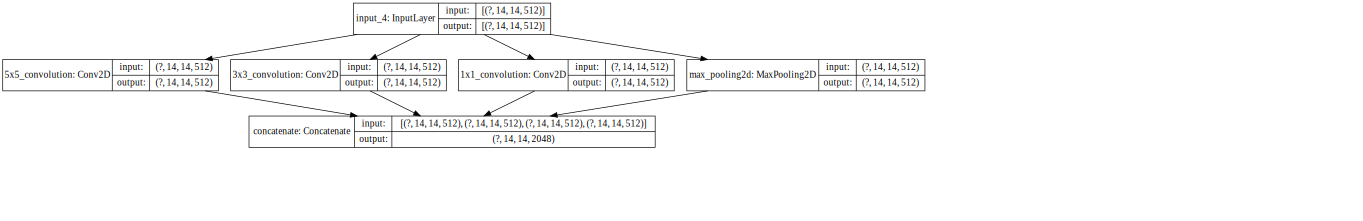

In [10]:
SVG(tf.keras.utils.model_to_dot(inception_no_bottleneck, show_shapes=True, expand_nested=False, dpi=49
                               ).create(prog='dot', format='svg'))

### Inception module with bottlenecks

In [11]:
previous_convolutional_output = tf.keras.layers.Input(shape=(14, 14, 512))

bn_5 = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(1, 1), name='5x5_bn', padding='same')(previous_convolutional_output)
conv_5 = tf.keras.layers.Conv2D(
    filters=512, kernel_size=(5, 5), name='5x5_convolution', padding='same')(bn_5)

bn_3 = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(1, 1), name='3x3_bn', padding='same')(previous_convolutional_output)
conv_3 = tf.keras.layers.Conv2D(
    filters=512, kernel_size=(3, 3), name='3x3_convolution', padding='same')(bn_3)

conv_1 = tf.keras.layers.Conv2D(
    filters=512, kernel_size=(1, 1), name='1x1_convolution', padding='same')(previous_convolutional_output)

max_pool_0 = tf.keras.layers.MaxPool2D(
    pool_size=(3, 3), strides=(1, 1), padding='same')(previous_convolutional_output)
cn_1 = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(1, 1), name='1x1_bn', padding='same')(max_pool_0)

inception_output = tf.keras.layers.Concatenate()([conv_5, conv_3, conv_1, cn_1])

inception_bottleneck = tf.keras.models.Model(inputs=previous_convolutional_output, outputs=inception_output)

inception_bottleneck.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 14, 14, 512) 0                                            
__________________________________________________________________________________________________
5x5_bn (Conv2D)                 (None, 14, 14, 128)  65664       input_5[0][0]                    
__________________________________________________________________________________________________
3x3_bn (Conv2D)                 (None, 14, 14, 128)  65664       input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 512)  0           input_5[0][0]                    
____________________________________________________________________________________________

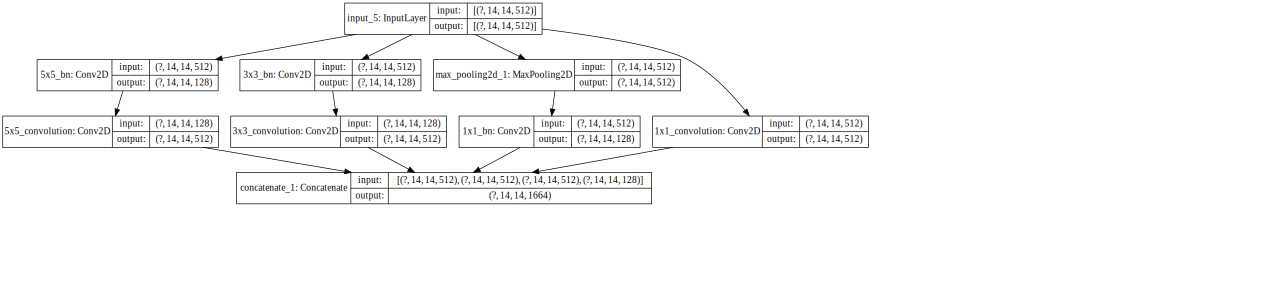

In [12]:
SVG(tf.keras.utils.model_to_dot(inception_bottleneck, show_shapes=True, expand_nested=False, dpi=49
                               ).create(prog='dot', format='svg'))

## Residual networks

In [21]:
previous_conv_output = tf.keras.layers.Input(shape=(14, 14, 128))

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), padding='same')(previous_conv_output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, previous_conv_output])

res_output = tf.keras.layers.ReLU()(x)

residual_block = tf.keras.models.Model(inputs=previous_conv_output, outputs=res_output)

residual_block.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 14, 14, 128) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 14, 14, 64)   8256        input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 14, 14, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
re_lu_12 (ReLU)                 (None, 14, 14, 64)   0           batch_normalization_15[0][0]     
____________________________________________________________________________________________

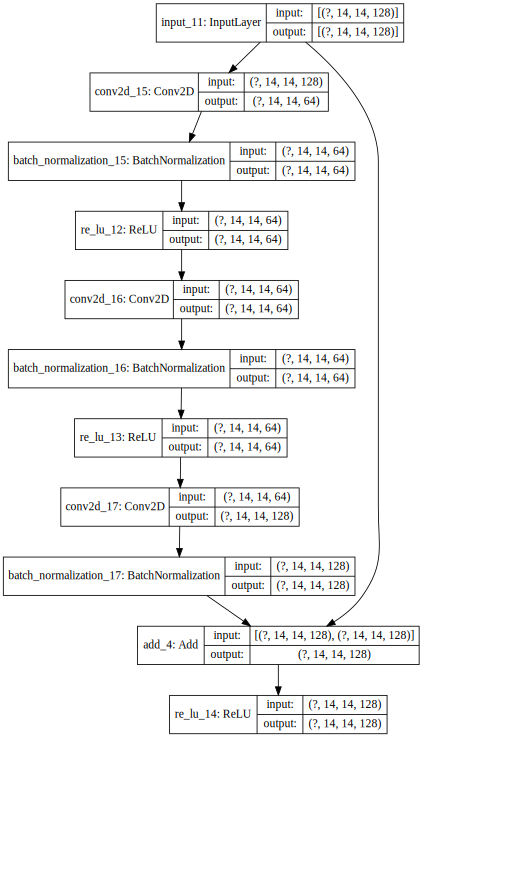

In [23]:
SVG(tf.keras.utils.model_to_dot(residual_block, show_shapes=True, expand_nested=False, dpi=60
                               ).create(prog='dot', format='svg'))